In [1]:
import os
import random
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, draw_box
from torchvision import transforms, models

import time
import copy

In [2]:
image_folder = 'data'
annotation_csv = 'data/annotation.csv'
# You shouldn't change the unlabeled_scene_index
# The first 106 scenes are unlabeled
unlabeled_scene_index = np.arange(106)
# The scenes from 106 - 133 are labeled
# You should devide the labeled_scene_index into two subsets (training and validation)
labeled_scene_index = np.arange(106, 134)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
random.seed(1008)
random.shuffle(labeled_scene_index)
train_idx = labeled_scene_index[:22]
val_idx = labeled_scene_index[22:26]
test_idx = labeled_scene_index[26:]


In [3]:
test_idx

array([120, 122])

In [4]:
transform = torchvision.transforms.Compose([
    # transforms.Resize(size=(256,256)),
    transforms.ToTensor(),
#     transforms.Normalize(img_net_mean.tolist(), img_net_std.tolist())
])

BATCH_SIZE=1

train_set = LabeledDataset(image_folder = image_folder,
                                  annotation_file = annotation_csv,
                                  scene_index = train_idx,
                                  transform = transform, 
                                  extra_info = True)

val_set = LabeledDataset(image_folder = image_folder,
                                  annotation_file = annotation_csv,
                                  scene_index = val_idx,
                                  transform = transform, 
                                  extra_info = True)


test_set = LabeledDataset(image_folder = image_folder,
                                  annotation_file = annotation_csv,
                                  scene_index = test_idx,
                                  transform = transform, 
                                  extra_info = True)

train_loader = torch.utils.data.DataLoader(train_set, batch_size =BATCH_SIZE, 
                                           shuffle = True, num_workers =2, 
                                           collate_fn = collate_fn)
val_loader = torch.utils.data.DataLoader(val_set, batch_size = BATCH_SIZE, 
                                         shuffle = True, num_workers =2, 
                                         collate_fn = collate_fn)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = BATCH_SIZE, 
                                         shuffle = True, num_workers =2, 
                                         collate_fn = collate_fn)


In [5]:
mini_set, _ = torch.utils.data.random_split(train_set, [5, len(train_set) - 5])
mini_val, _ = torch.utils.data.random_split(val_set, [3, len(val_set)-3])

mini_loader = torch.utils.data.DataLoader(mini_set, batch_size = BATCH_SIZE, 
                                          shuffle = True, num_workers = 2, 
                                          collate_fn = collate_fn)

mini_val_loader = torch.utils.data.DataLoader(mini_val, batch_size = BATCH_SIZE, 
                                          shuffle = True, num_workers = 2, 
                                          collate_fn = collate_fn)

In [6]:
def position_concat_features(feature_maps):
    '''
    feature maps be in shape B V C H W
    returns in shape B C H W
    '''
    first_row = torch.cat([feature_maps[:, i] for i in range(3)], dim=3)
    second_row = torch.cat([feature_maps[:, i] for i in range(3,6)], dim=3)
    result = torch.cat([first_row, second_row], dim=2)
    return result

In [7]:
class upsample(nn.Module):

    def __init__(self, if_deconv, channels=None, kernel_size=3, stride=3):
        super(upsample, self).__init__()
        if if_deconv:
            self.upsample = nn.ConvTranspose2d(channels, channels, 
                                               kernel_size= kernel_size, 
                                               stride=stride, bias=False)
        else:
            self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x):
        x = self.upsample(x)

        return x

class double_conv(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(*[
                nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1), 
                nn.BatchNorm2d(out_channel),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channel), 
                nn.ReLU(inplace=True)
        ])
        
    def forward(self, x):
        x = self.conv(x)
        return x
    

In [8]:
def position_concat_features(feature_maps):
    '''
    feature maps be in shape B V C H W
    returns in shape B C H W
    '''
    first_row = torch.cat([feature_maps[:, i] for i in range(3)], dim=3)
    second_row = torch.cat([feature_maps[:, i] for i in range(3,6)], dim=3)
    result = torch.cat([first_row, second_row], dim=2)
    return result

def get_upsampling_weight(in_channels, out_channels, kernel_size):
    """Make a 2D bilinear kernel suitable for upsampling"""
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:kernel_size, :kernel_size]
    filt = (1 - abs(og[0] - center) / factor) * \
           (1 - abs(og[1] - center) / factor)
    weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size),
                      dtype=np.float64)
    weight[range(in_channels), range(out_channels), :, :] = filt
    return torch.from_numpy(weight).float()

In [9]:
def dice_loss(true, preds, epsilon = 1e-4):
    #sh1, sh2 = preds.size()
    true = true.view(1, -1)
    preds = preds.view(1, -1)
    prod = torch.sum(true*preds,dim = 1)
    sum_tnp = torch.sum(true + preds, dim = 1)
    num = torch.sum(prod)
    denom = torch.sum(sum_tnp) + epsilon
    loss = 1 - 2*(num/denom)

    return torch.mean(loss)

def dice_loss2(pred,target):
    numerator = 2 * torch.sum(pred * target)
    denominator = torch.sum(pred + target)
    return 1 - (numerator + 1) / (denominator + 1)


def compute_dice(true, preds, epsilon = 1e-7):
    #sh1, sh2 = preds.size()
    true = true.view(1, -1)
    preds = preds.view(1, -1)
    
    prod = torch.sum(true*preds,dim = 1)
    sum_tnp = torch.sum(true + preds, dim = 1)
    
    num = torch.sum(prod)
    denom = torch.sum(sum_tnp) + epsilon

    return torch.mean(num/denom)

def compute_ts_road_map(road_map1, road_map2):
    tp = (road_map1 * road_map2).sum()

    return tp * 1.0 / (road_map1.sum() + road_map2.sum() - tp)

# def loss_function(target, prediction,  mu, logvar):
#     LOSS = dice_loss(target, prediction)
#     KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

#     return 0.9*LOSS + 0.1*KLD



def loss_function(target, prediction, mu, logvar):
    LOSS = dice_loss(target, prediction)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return 0.9*LOSS + 0.1*KLD

In [10]:
class encoder_for_vae(nn.Module):

    def __init__(self):
        super(encoder_for_vae, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(512, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )

        self.mu_dec = nn.Linear(14336, 512)
        self.logvar_dec = nn.Linear(14336, 512)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 14336)
        mu = self.mu_dec(x)
        logvar = self.logvar_dec(x)

        return mu, logvar

class decoder_conv(nn.Module):
    def __init__(self, if_deconv):
        super(decoder_conv, self).__init__()

        self.up1 = upsample(if_deconv=if_deconv, channels=128)
        self.conv1 = double_conv(128, 256)
        self.up2 = upsample(if_deconv=if_deconv, channels=256)
        self.conv2 = double_conv(256, 256)
        self.up3 = upsample(if_deconv=if_deconv, channels=256)
        self.conv3 = double_conv(256, 256)
        self.up4 = upsample(if_deconv=if_deconv, channels=256)
        self.conv4 = double_conv(256, 256)
        self.up5 = upsample(if_deconv=if_deconv, channels=256)
        self.conv5 = double_conv(256, 256)
        self.up6 = upsample(if_deconv = if_deconv, channels = 256, kernel_size=2, stride=2)
        self.conv6  =double_conv(256, 128)
        
        self.conv_out = nn.Conv2d(128, 1, 3, padding=1)
        self.final_upsample = nn.Upsample((800, 800), mode='bilinear')
        self.sigmoid = nn.Sigmoid()
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d):
                assert m.kernel_size[0] == m.kernel_size[1]
                initial_weight = get_upsampling_weight(
                    m.in_channels, m.out_channels, m.kernel_size[0])
                m.weight.data.copy_(initial_weight)

    def forward(self, x):
        x = x.view(-1, 128, 2, 2)
        x = self.up1(x)
        x = self.conv1(x)
        #print(x.shape)
        x = self.up2(x)
        x = self.conv2(x)
        #print(x.shape)
        x = self.up3(x)
        x = self.conv3(x)
        #print(x.shape)
        x = self.up4(x)
        x = self.conv4(x)
        #print(x.shape)
        x = self.up5(x)
        x = self.conv5(x)
        #print('after 5')
        #print(x.shape)
        x = self.up6(x)
        x = self.conv6(x)
        #print(x.shape)
        x = self.conv_out(x)
        #print(x.shape)
        x = self.final_upsample(x)
        #print(x.shape)
        x = self.sigmoid(x)

        return x
    
class vae_mapping(nn.Module):

    def __init__(self):
        super(vae_mapping, self).__init__()

        self.feature_extractor = torchvision.models.resnet18(pretrained=False)
        self.res_head = nn.Sequential(*list(self.feature_extractor.children())[:4])
        self.encoder = nn.Sequential(*list(self.feature_extractor.children())[4:-2])
        
        self.encoder_for_vae = encoder_for_vae()
        self.decoder = decoder_conv(if_deconv=True)

    def reparameterize(self, is_training, mu, logvar):
        if is_training:
            std = torch.exp(0.5*logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def forward(self, x, is_training, defined_mu=None):
        B,V,C,H,W = x.shape
        
        x = x.view([B*V, C, H, W])
        feature_maps = self.res_head(x)
        feature_maps = feature_maps.view([B,V] + list(feature_maps.size()[1:]))
        feature_maps = position_concat_features(feature_maps)
        
        x = self.encoder(feature_maps)
        
        mu, logvar = self.encoder_for_vae(x)
        
        z = self.reparameterize(is_training, mu, logvar)
        
        
        if defined_mu is not None:
            z = defined_mu
            
        pred_map = self.decoder(z)

        return pred_map, mu, logvar

In [11]:
def train_eval_model(model, dataloaders,criterion, optimizer, 
                num_epochs,print_every=10, eval_every = 1, to_eval = False):
    
    start_time = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10
    
    dice_dict={'train':[], 'val':[]}
    loss_dict = {'train':[], 'val':[]}
    ts_dict = []

    
    for epoch in range(num_epochs):
        epoch_start = time.time()
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-'*10)

        if (to_eval) and (epoch%eval_every == 0):
            phases = ['train', 'val']
        else:
            phases = ['train']
            
        for phase in phases:
            # print(len(dataloaders[phase]))
            
            curr_loss = 0.0
            curr_dice = 0.0
            if phase == 'train':
                model.train()

            else:
                curr_ts = 0.0
                model.eval()
                
            for i, (sample, target, roadmap, extra) in enumerate(dataloaders[phase]):
                
                #target = torch.rot90(roadmap[0].int(), 1, [0,1]).type(torch.LongTensor).to(device)
                target = torch.stack(roadmap).type(torch.LongTensor)
                inputs = torch.stack(sample).type(torch.FloatTensor).to(device)
 
                
                optimizer.zero_grad()
                
                
                if phase == 'train':
                    with torch.set_grad_enabled(phase=='train'):
                        output, mu, logvar = model(inputs, is_training=True)
                        loss = criterion(target.cpu(), output.cpu().squeeze(1), mu.cpu(), logvar.cpu())
                        loss.backward()
                        optimizer.step()
                else:
                    with torch.set_grad_enabled(phase == 'train'):
                        output, mu, logvar = model(inputs, is_training =False)
                        loss = criterion(target.cpu(), output.cpu().squeeze(1), mu.cpu(), logvar.cpu())
                    
                with torch.no_grad():
                    dice_score = compute_dice(target.cpu(), output.cpu().squeeze(1))

                curr_loss += loss.item()
                curr_dice += dice_score
                if phase == 'val':
                    with torch.no_grad():
                        curr_ts += compute_ts_road_map(target.cpu(), output.cpu().squeeze(1))
                
            
            loss_dict[phase].append(curr_loss/len(dataloaders[phase]))
            dice_dict[phase].append(curr_dice/len(dataloaders[phase]))
            
            print('current epoch %s dice loss is %f'%(phase, curr_loss))
            print('current epoch %s dice coef is %f'%(phase, curr_dice))
            print('%sing 1 epoch takes %f'%(phase, time.time() - epoch_start))
            
            if phase == 'val':
                ts_dict.append(curr_ts/len(dataloaders[phase]))
                print('current ts is %f'%(curr_ts/len(dataloaders[phase])))
                
                # val: after finishing 1 epoch
                if(curr_loss/len(dataloaders[phase])) < best_loss:
                    print('saving best model')
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save(best_model_wts, '/scratch/ht1162/DLSP20Dataset/vae_model_v2.pth')
                    best_loss = curr_loss/len(dataloaders[phase])
                                 
        if epoch %print_every == 0:
            print('printing test image')
            fig, ax = plt.subplots(5, 2, figsize=(15,30))
            test_idx = [173, 289, 441, 361, 9]
            for fig_i, i in enumerate(test_idx):
                inputs = val_set[i][0].unsqueeze(0).to(device)
                with torch.no_grad():
                    outputs = model(inputs, is_training=False)[0].cpu().squeeze().detach()

                ax[fig_i, 0].imshow(val_set[i][2].cpu().numpy())

                ax[fig_i, 1].imshow((outputs>0.5).numpy())
            plt.show()
            
    print('This training takes ', time.time() - start_time)
    if to_eval:
        print_phase = ['train', 'val']
    else:
        print_phase = ['train']
    for phase in print_phase:
        fig = plt.figure()
        plt.plot(loss_dict[phase])
        plt.title('%s Loss per epoch'%(phase))
        plt.show()

        fig = plt.figure()
        plt.plot(dice_dict[phase])
        plt.title('%s Dice per epoch'%(phase))
        plt.show()
    
    
    return model, loss_dict, dice_dict, ts_dict, best_model_wts
    
    
    

In [12]:
dataloaders = {'train': train_loader, 'val': val_loader}
miniloaders = {'train': mini_loader, 'val': mini_val_loader}

Epoch 1/10
----------


/home/ht1162/miniconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


current epoch train dice loss is 538.873091
current epoch train dice coef is 1101.058594
training 1 epoch takes 1675.906800
current epoch val dice loss is 103.156378
current epoch val dice coef is 195.491165
valing 1 epoch takes 1775.999305
current ts is 0.651039
saving best model
printing test image


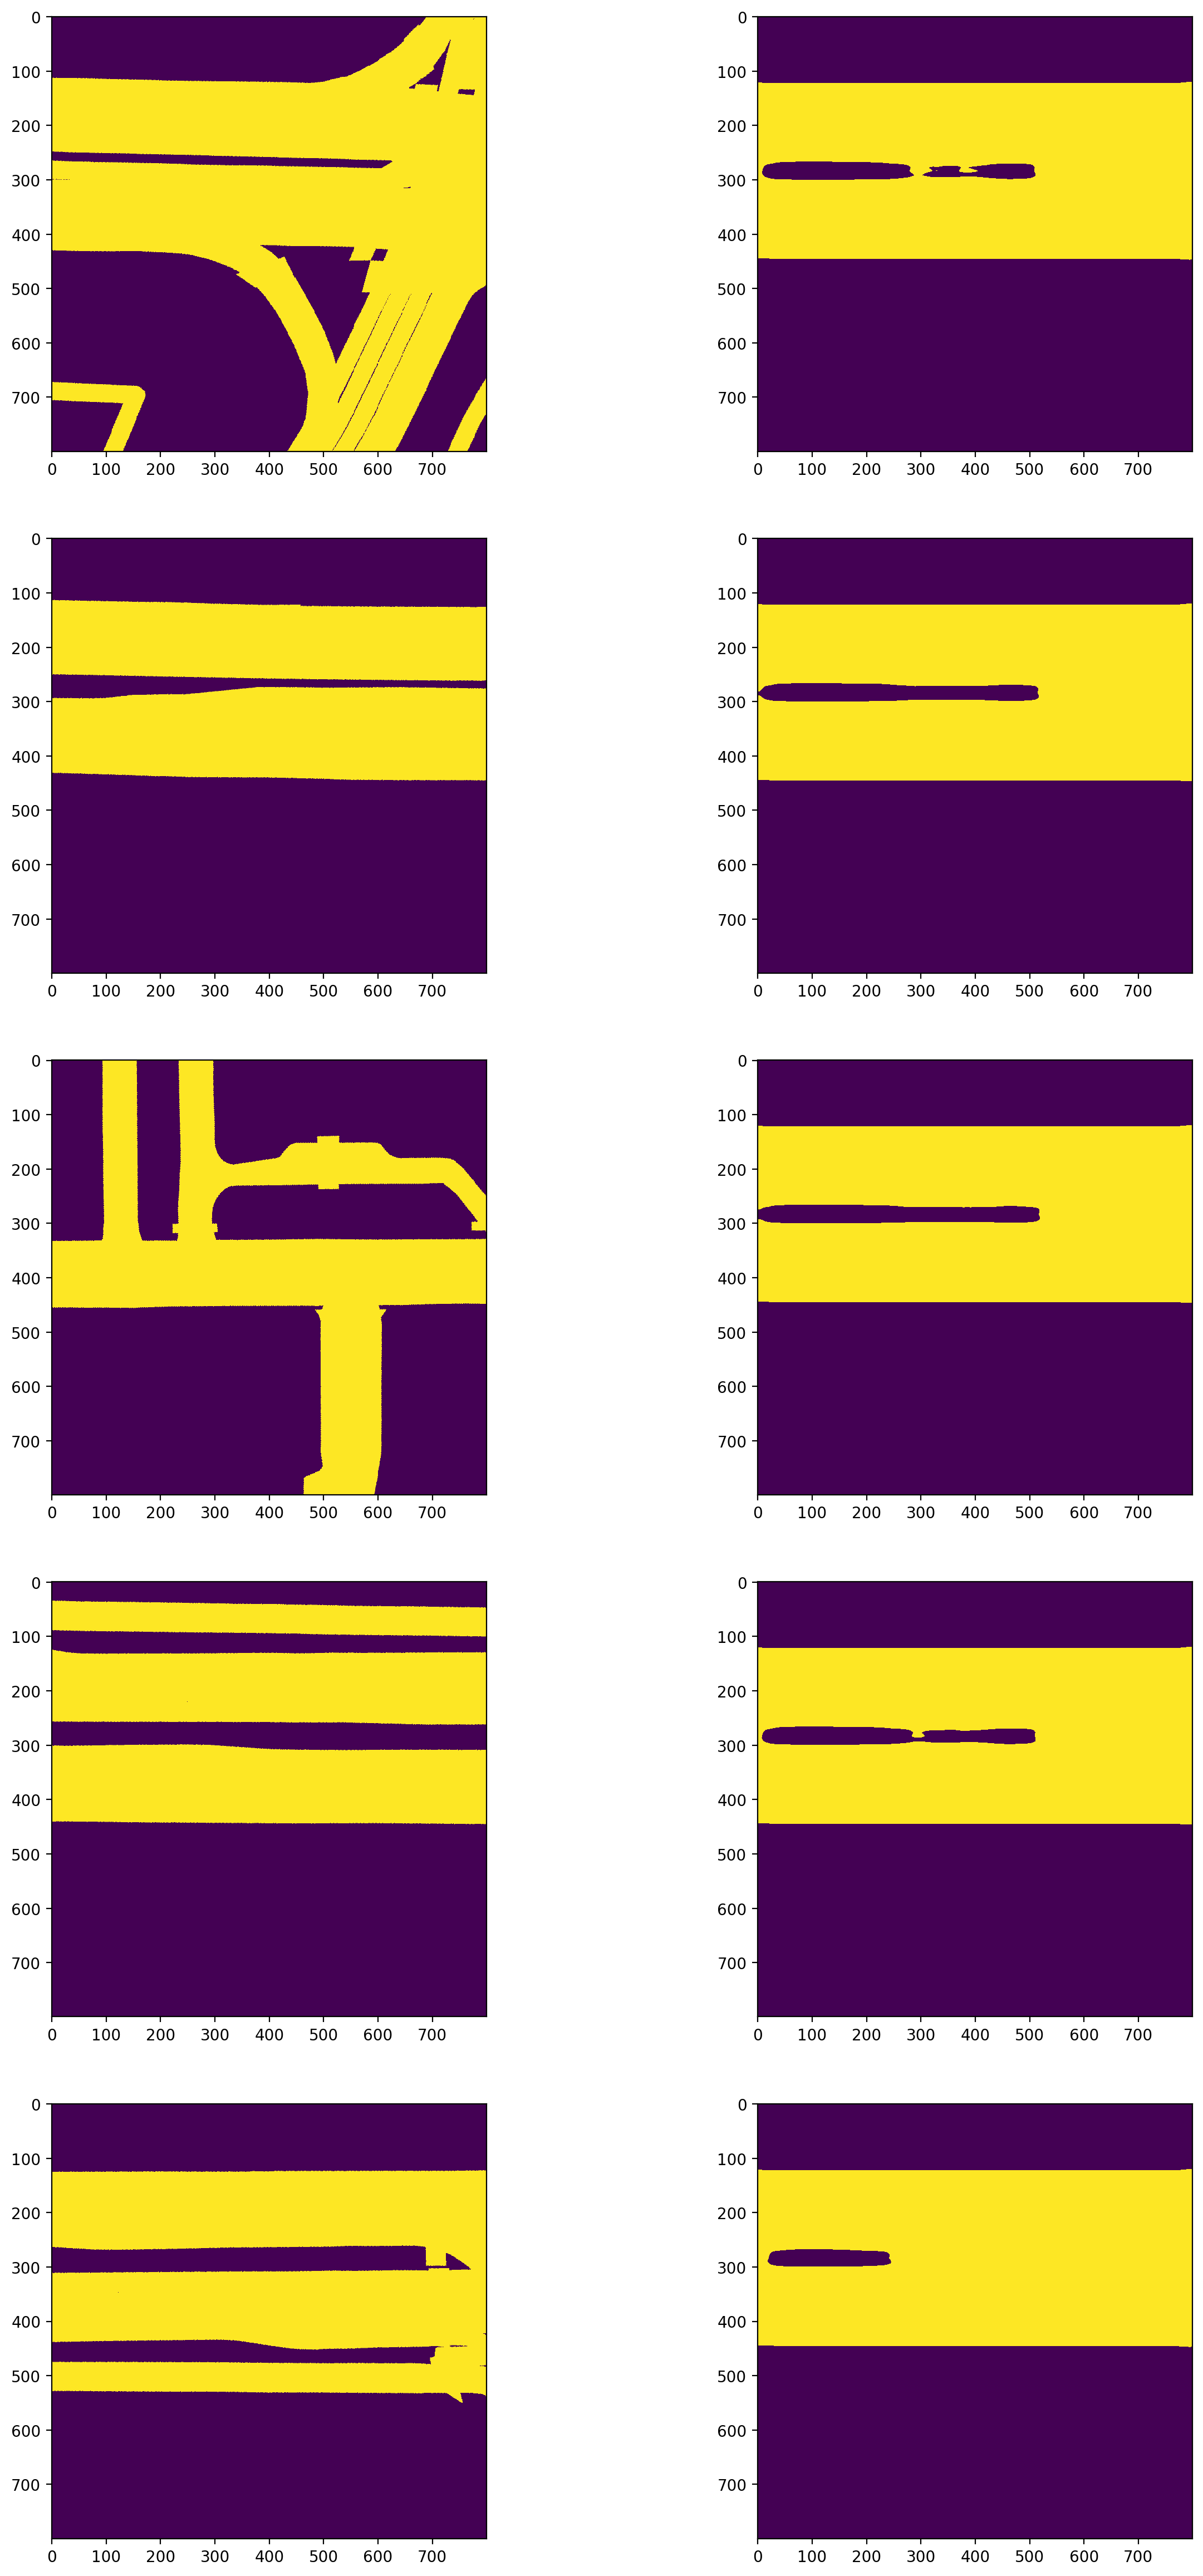

Epoch 2/10
----------
current epoch train dice loss is 511.887946
current epoch train dice coef is 1106.771362
training 1 epoch takes 1680.301284
Epoch 3/10
----------
current epoch train dice loss is 509.566642
current epoch train dice coef is 1107.602539
training 1 epoch takes 1679.326791
current epoch val dice loss is 100.751003
current epoch val dice coef is 196.871155
valing 1 epoch takes 1780.474301
current ts is 0.658791
saving best model
Epoch 4/10
----------
current epoch train dice loss is 503.923351
current epoch train dice coef is 1110.148804
training 1 epoch takes 1677.426841
Epoch 5/10
----------
current epoch train dice loss is 499.819932
current epoch train dice coef is 1110.812988
training 1 epoch takes 1683.358996
current epoch val dice loss is 101.272217
current epoch val dice coef is 196.098297
valing 1 epoch takes 1785.453582
current ts is 0.654079
Epoch 6/10
----------
current epoch train dice loss is 498.728215
current epoch train dice coef is 1110.989502
trainin

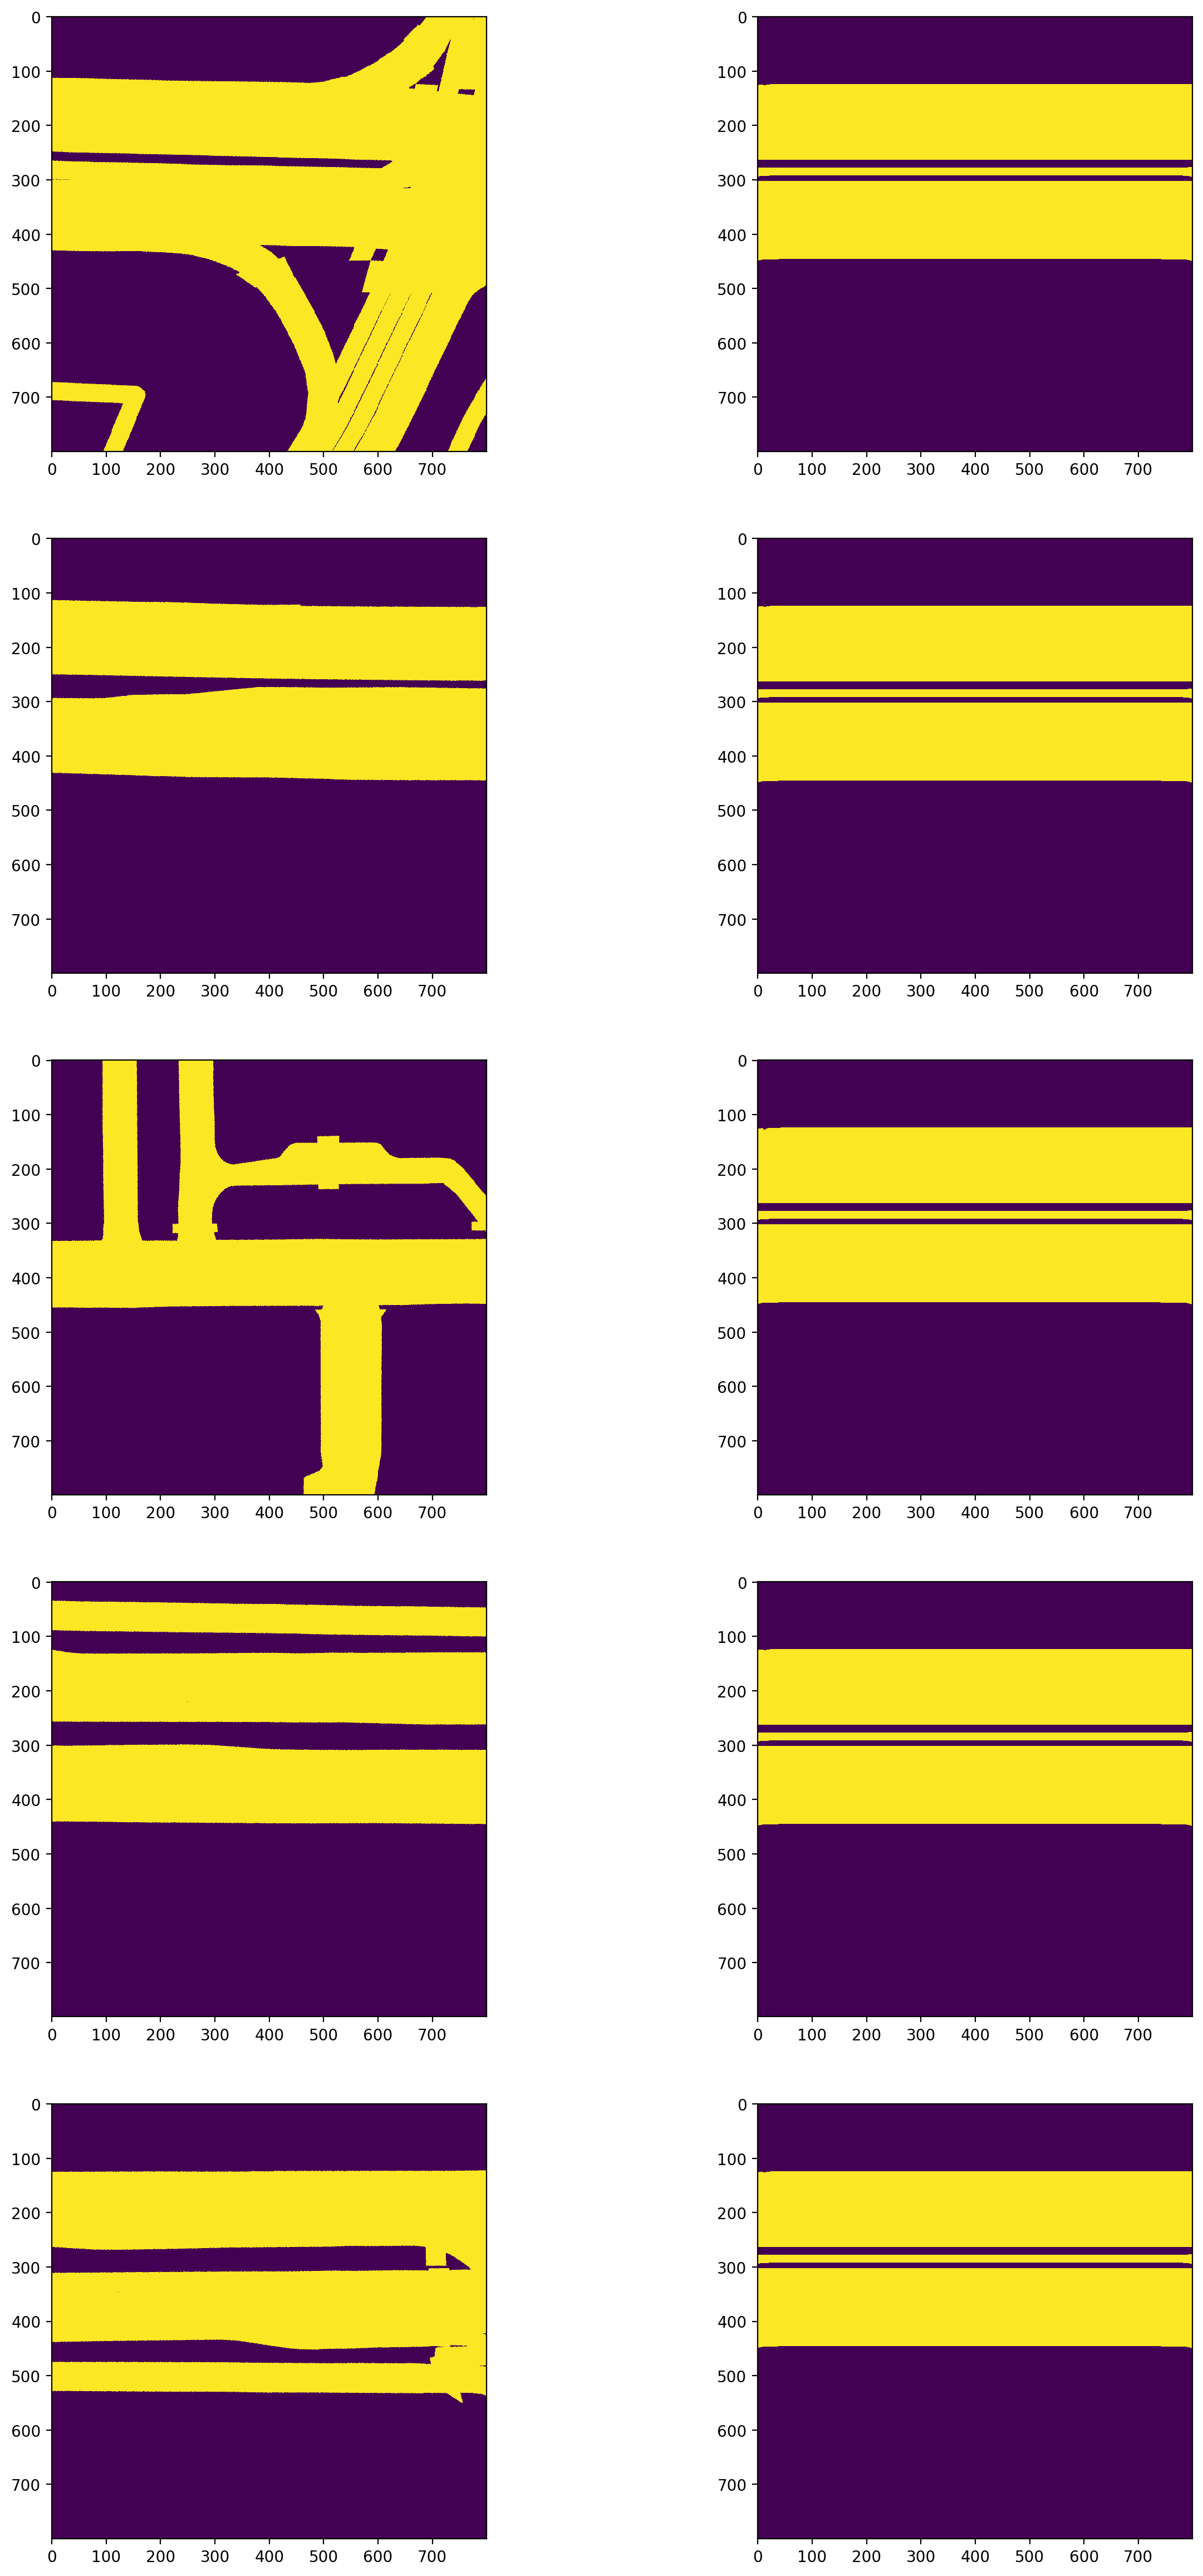

Epoch 7/10
----------
current epoch train dice loss is 498.225599
current epoch train dice coef is 1111.114380
training 1 epoch takes 1673.423438
current epoch val dice loss is 114.649810
current epoch val dice coef is 188.915100
valing 1 epoch takes 1773.227350
current ts is 0.615465
Epoch 8/10
----------
current epoch train dice loss is 497.439250
current epoch train dice coef is 1111.297485
training 1 epoch takes 1673.488161
Epoch 9/10
----------
current epoch train dice loss is 496.343079
current epoch train dice coef is 1111.612793
training 1 epoch takes 1673.650380
current epoch val dice loss is 242.610337
current epoch val dice coef is 117.417908
valing 1 epoch takes 1774.851900
current ts is 0.319952
Epoch 10/10
----------
current epoch train dice loss is 494.527242
current epoch train dice coef is 1111.813232
training 1 epoch takes 1674.722131
This training takes  17286.075163841248


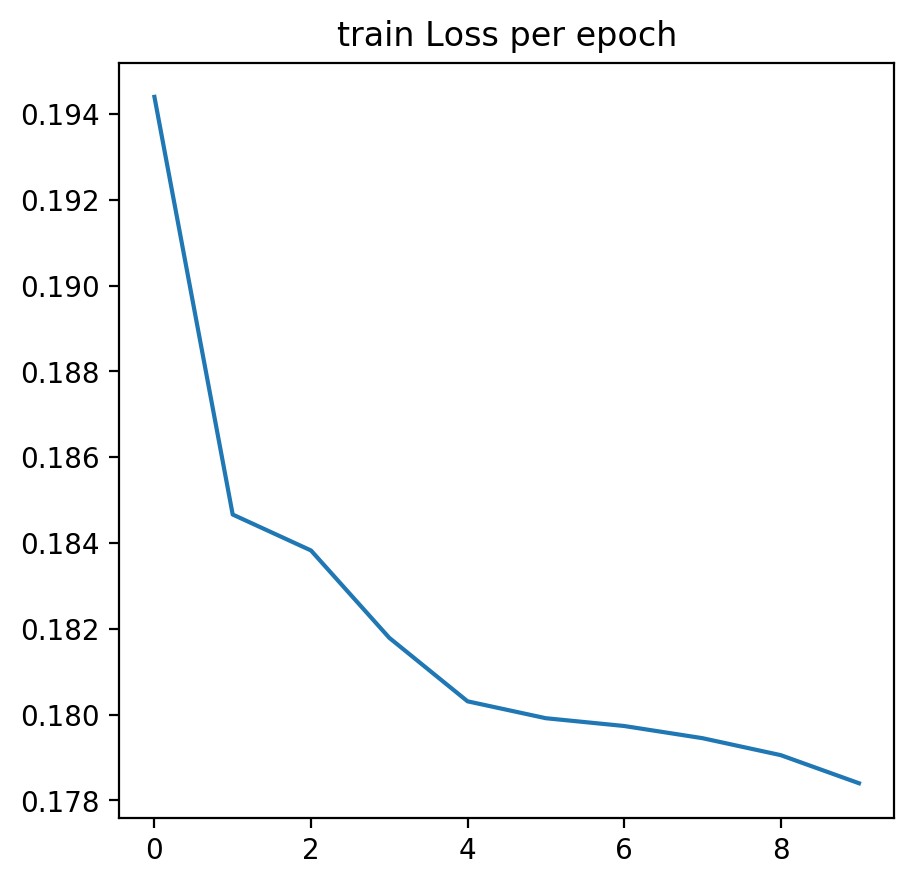

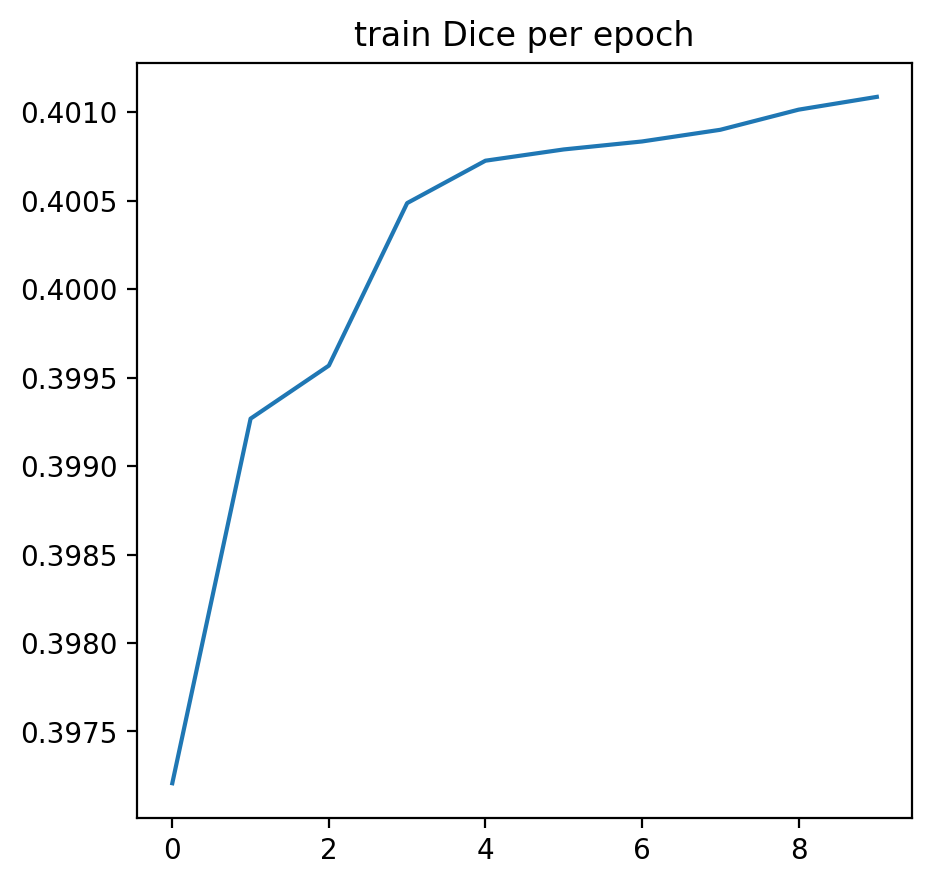

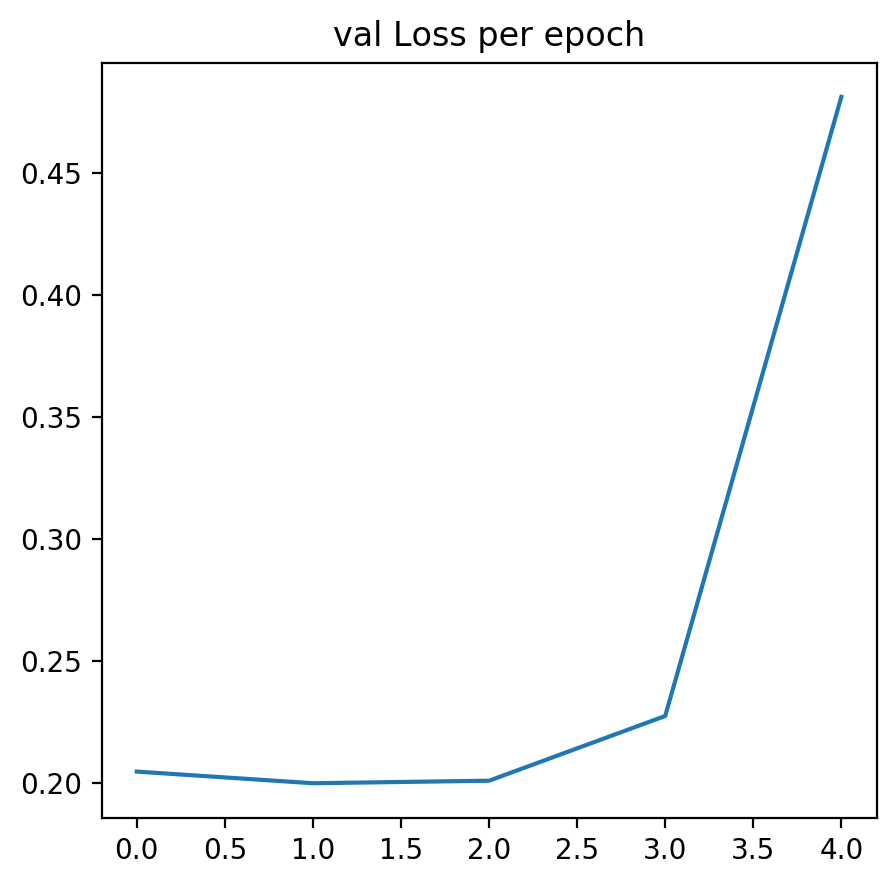

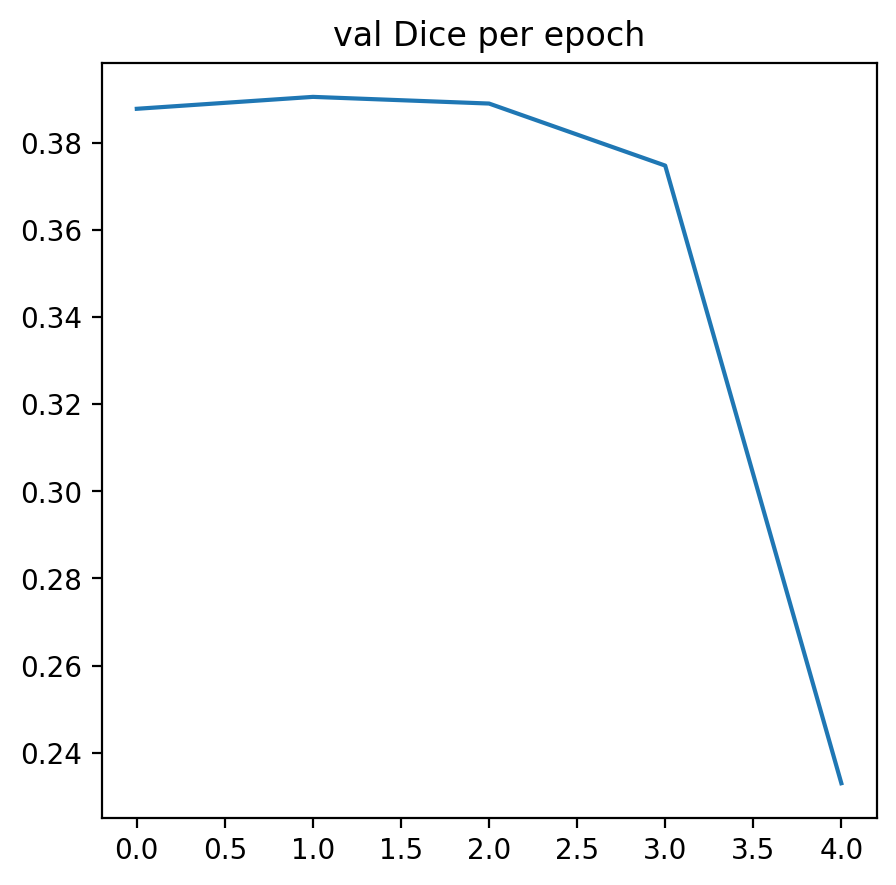

In [140]:

my_model = vae_mapping().cuda()
optimizer = torch.optim.Adam(my_model.parameters(), lr = 1e-4)

model, loss_dict, dice_dict, ts_dict, best_model_wts = train_eval_model(my_model, dataloaders ,loss_function, 
                                                                        optimizer, num_epochs=10,print_every=5, 
                                                                        eval_every = 2, to_eval = True)

In [13]:
def train_eval_model2(model, dataloaders,criterion, optimizer, best_loss,
                num_epochs,print_every=10, eval_every = 1, to_eval = False,):
    
    start_time = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    
    dice_dict={'train':[], 'val':[]}
    loss_dict = {'train':[], 'val':[]}
    ts_dict = []

    
    for epoch in range(num_epochs):
        epoch_start = time.time()
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-'*10)

        if (to_eval) and (epoch%eval_every == 0):
            phases = ['train', 'val']
        else:
            phases = ['train']
            
        for phase in phases:
            # print(len(dataloaders[phase]))
            
            curr_loss = 0.0
            curr_dice = 0.0
            if phase == 'train':
                model.train()

            else:
                curr_ts = 0.0
                model.eval()
                
            for i, (sample, target, roadmap, extra) in enumerate(dataloaders[phase]):
                
                #target = torch.rot90(roadmap[0].int(), 1, [0,1]).type(torch.LongTensor).to(device)
                target = torch.stack(roadmap).type(torch.LongTensor)
                inputs = torch.stack(sample).type(torch.FloatTensor).to(device)
 
                
                optimizer.zero_grad()
                
                
                if phase == 'train':
                    with torch.set_grad_enabled(phase=='train'):
                        output, mu, logvar = model(inputs, is_training=True)
                        loss = criterion(target.cpu(), output.cpu().squeeze(1), mu.cpu(), logvar.cpu())
                        loss.backward()
                        optimizer.step()
                else:
                    with torch.set_grad_enabled(phase == 'train'):
                        output, mu, logvar = model(inputs, is_training =False)
                        loss = criterion(target.cpu(), output.cpu().squeeze(1), mu.cpu(), logvar.cpu())
                    
                with torch.no_grad():
                    dice_score = compute_dice(target.cpu(), output.cpu().squeeze(1))

                curr_loss += loss.item()
                curr_dice += dice_score
                if phase == 'val':
                    with torch.no_grad():
                        curr_ts += compute_ts_road_map(target.cpu(), output.cpu().squeeze(1))
                
            
            loss_dict[phase].append(curr_loss/len(dataloaders[phase]))
            dice_dict[phase].append(curr_dice/len(dataloaders[phase]))
            
            print('current epoch %s dice loss is %f'%(phase, curr_loss))
            print('current epoch %s dice coef is %f'%(phase, curr_dice))
            print('%sing 1 epoch takes %f'%(phase, time.time() - epoch_start))
            
            if phase == 'val':
                ts_dict.append(curr_ts/len(dataloaders[phase]))
                print('current ts is %f'%(curr_ts/len(dataloaders[phase])))
                
                # val: after finishing 1 epoch
                if(curr_loss/len(dataloaders[phase])) < best_loss:
                    print('saving best model')
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save(best_model_wts, '/scratch/ht1162/DLSP20Dataset/vae_model_v3.pth')
                    best_loss = curr_loss/len(dataloaders[phase])
                                 
        if epoch %print_every == 0:
            print('printing test image')
            fig, ax = plt.subplots(5, 2, figsize=(15,30))
            test_idx = [173, 289, 441, 361, 9]
            for fig_i, i in enumerate(test_idx):
                inputs = val_set[i][0].unsqueeze(0).to(device)
                with torch.no_grad():
                    outputs = model(inputs, is_training=False)[0].cpu().squeeze().detach()

                ax[fig_i, 0].imshow(val_set[i][2].cpu().numpy())

                ax[fig_i, 1].imshow((outputs>0.5).numpy())
            plt.show()
            
    print('This training takes ', time.time() - start_time)
    if to_eval:
        print_phase = ['train', 'val']
    else:
        print_phase = ['train']
    for phase in print_phase:
        fig = plt.figure()
        plt.plot(loss_dict[phase])
        plt.title('%s Loss per epoch'%(phase))
        plt.show()

        fig = plt.figure()
        plt.plot(dice_dict[phase])
        plt.title('%s Dice per epoch'%(phase))
        plt.show()
    
    
    return model, loss_dict, dice_dict, ts_dict, best_model_wts
    
    
    

In [16]:
model = vae_mapping().to(device)
model.load_state_dict(torch.load('/scratch/ht1162/DLSP20Dataset/vae_model_v2.pth'))

<All keys matched successfully>

In [18]:
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)


Epoch 1/10
----------


/home/ht1162/miniconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


current epoch train dice loss is 506.700524
current epoch train dice coef is 1109.251831
training 1 epoch takes 1688.500213
current epoch val dice loss is 105.822496
current epoch val dice coef is 193.462112
valing 1 epoch takes 1866.694184
current ts is 0.640541
printing test image


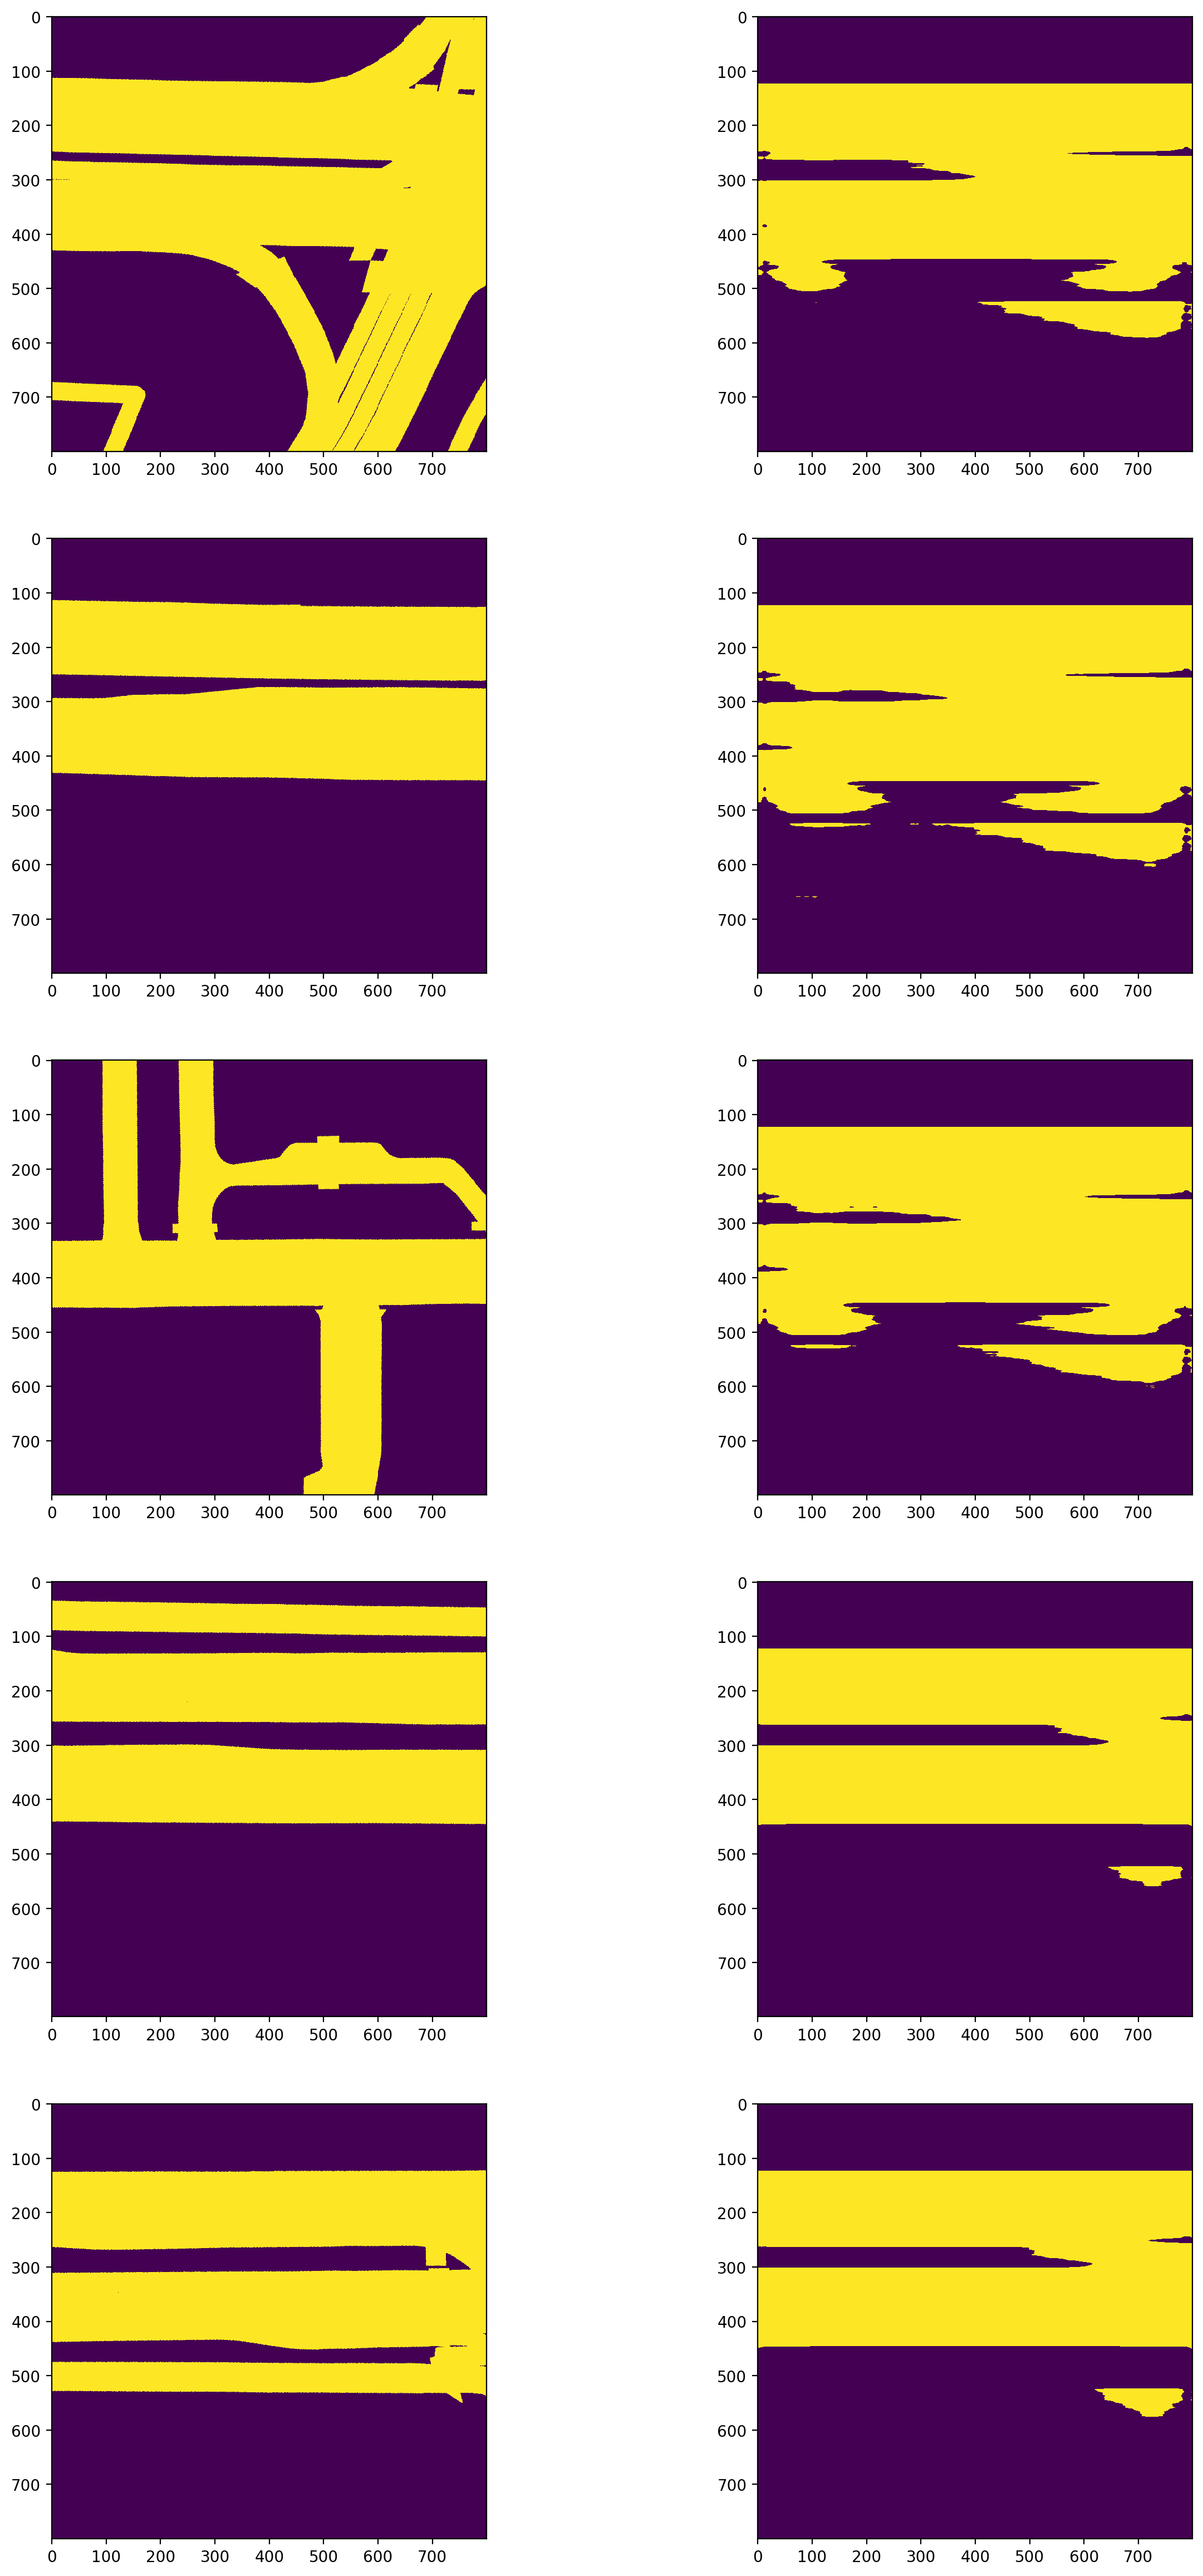

Epoch 2/10
----------
current epoch train dice loss is 507.400593
current epoch train dice coef is 1107.430908
training 1 epoch takes 1689.084032
Epoch 3/10
----------
current epoch train dice loss is 502.327605
current epoch train dice coef is 1110.249390
training 1 epoch takes 1692.759660
current epoch val dice loss is 105.380167
current epoch val dice coef is 194.758591
valing 1 epoch takes 1793.309238
current ts is 0.648642
Epoch 4/10
----------
current epoch train dice loss is 501.706507
current epoch train dice coef is 1109.964233
training 1 epoch takes 1692.105957
Epoch 5/10
----------
current epoch train dice loss is 502.220558
current epoch train dice coef is 1109.772827
training 1 epoch takes 1692.618711
current epoch val dice loss is 142.151589
current epoch val dice coef is 173.207031
valing 1 epoch takes 1793.361155
current ts is 0.535568
Epoch 6/10
----------
current epoch train dice loss is 503.066267
current epoch train dice coef is 1109.684326
training 1 epoch takes 16

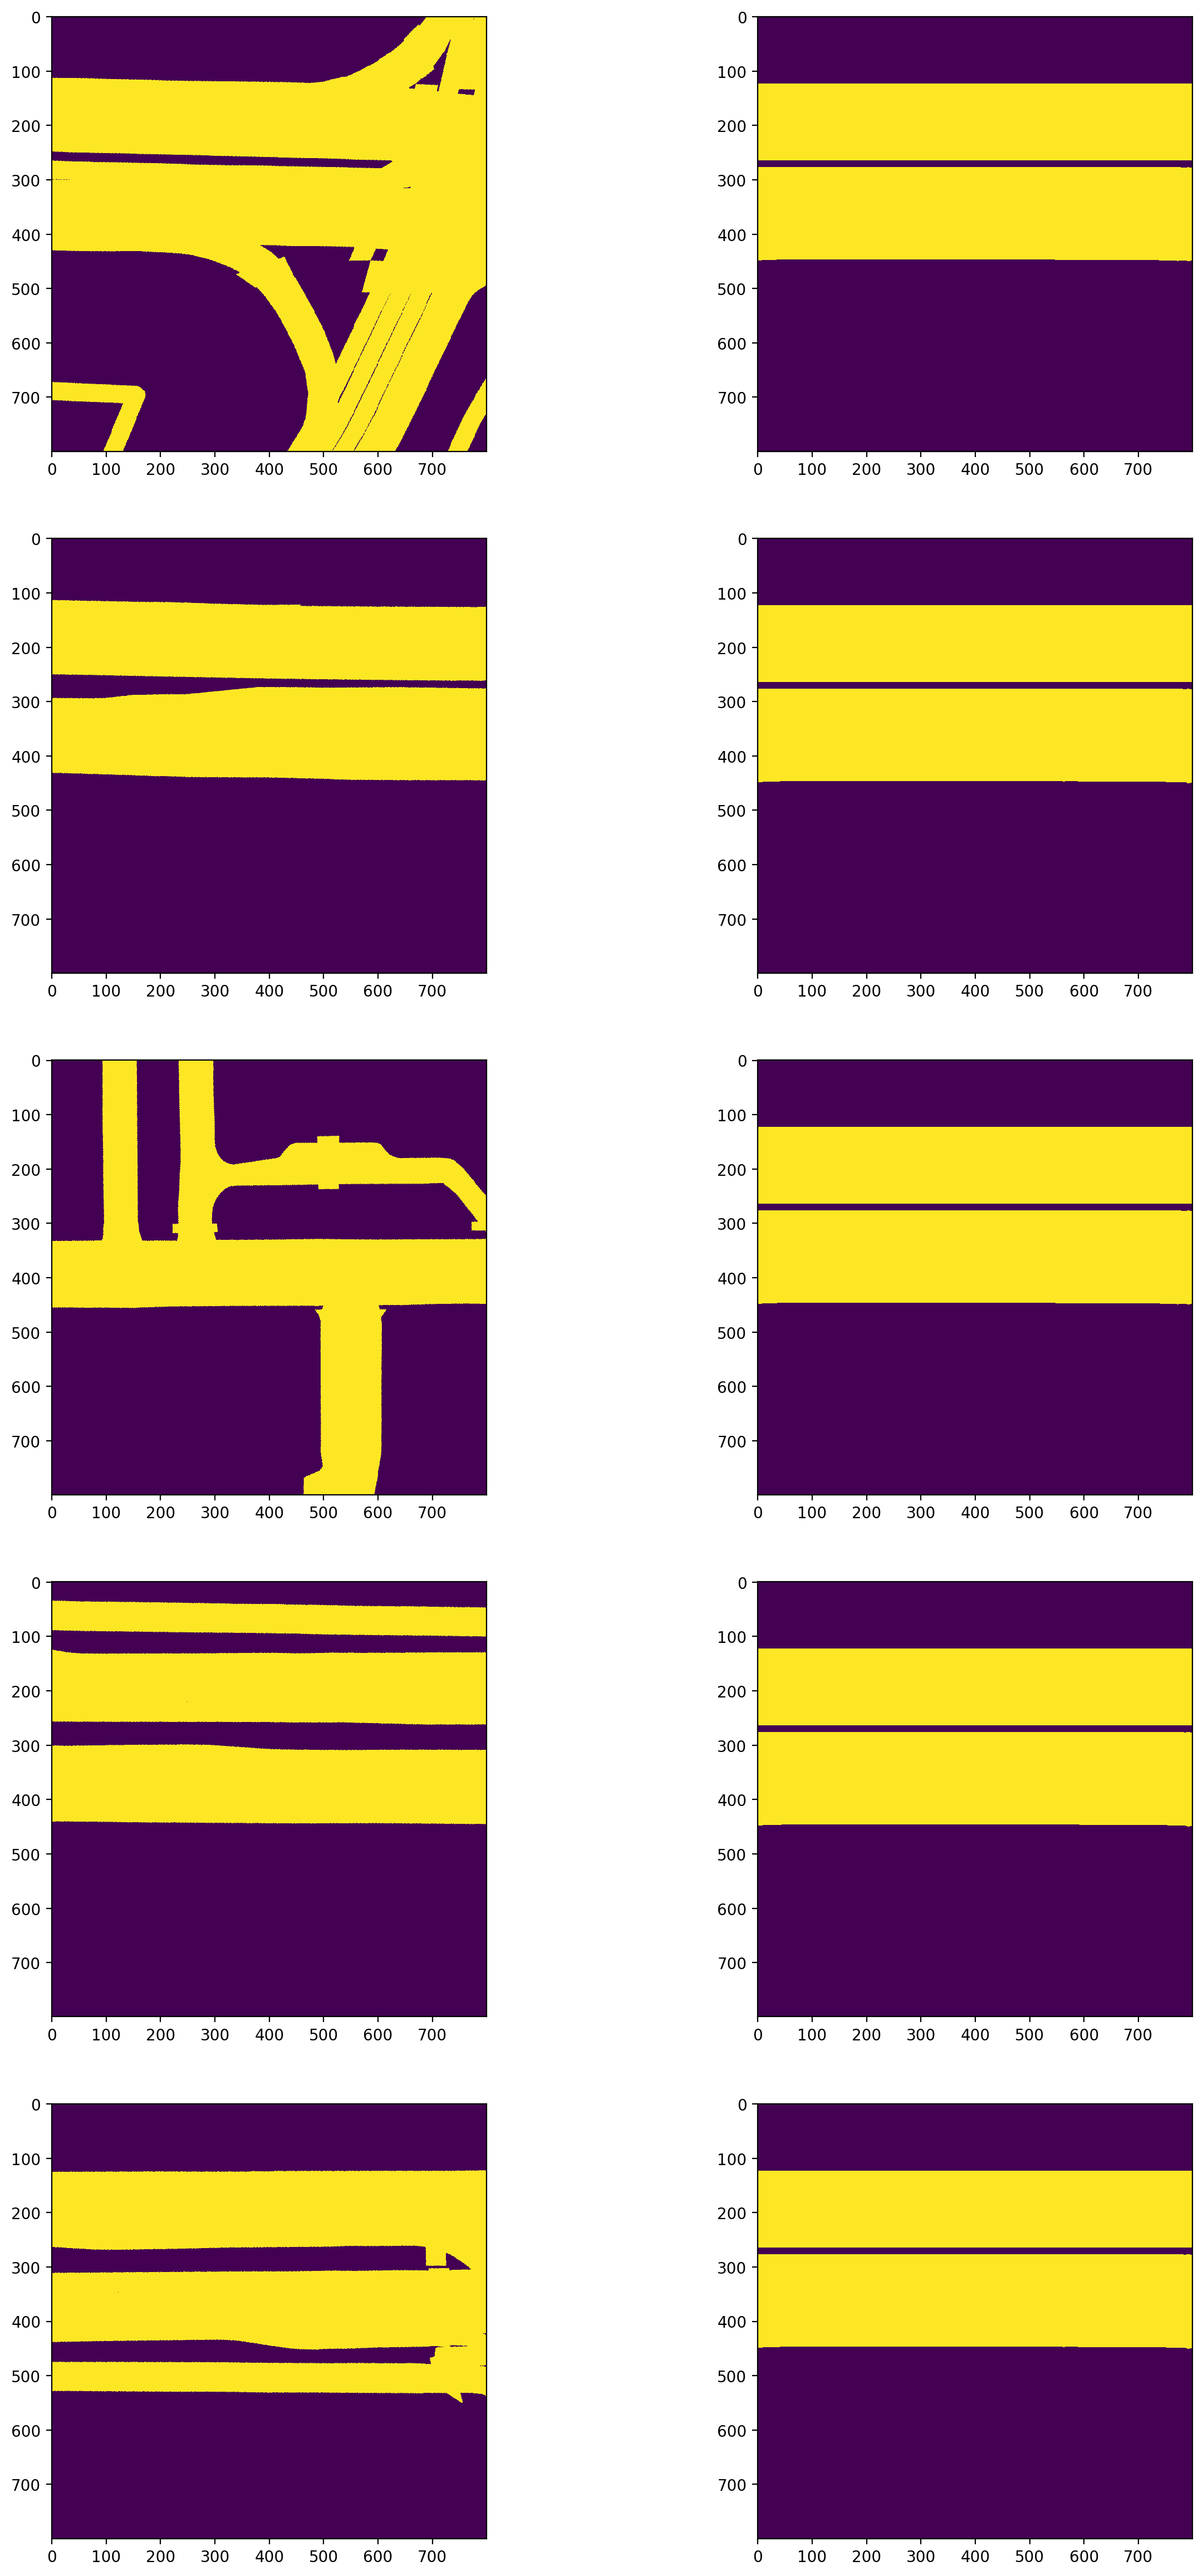

Epoch 7/10
----------
current epoch train dice loss is 500.287514
current epoch train dice coef is 1109.705566
training 1 epoch takes 1688.330438
current epoch val dice loss is 102.587126
current epoch val dice coef is 195.448563
valing 1 epoch takes 1788.549207
current ts is 0.649898
Epoch 8/10
----------
current epoch train dice loss is 497.718704
current epoch train dice coef is 1110.181274
training 1 epoch takes 1687.545981
Epoch 9/10
----------
current epoch train dice loss is 497.995979
current epoch train dice coef is 1110.024536
training 1 epoch takes 1689.805582
current epoch val dice loss is 179.500669
current epoch val dice coef is 152.302490
valing 1 epoch takes 1792.352039
current ts is 0.441574
Epoch 10/10
----------
current epoch train dice loss is 497.692721
current epoch train dice coef is 1109.903564
training 1 epoch takes 1688.693599
This training takes  17491.538687229156


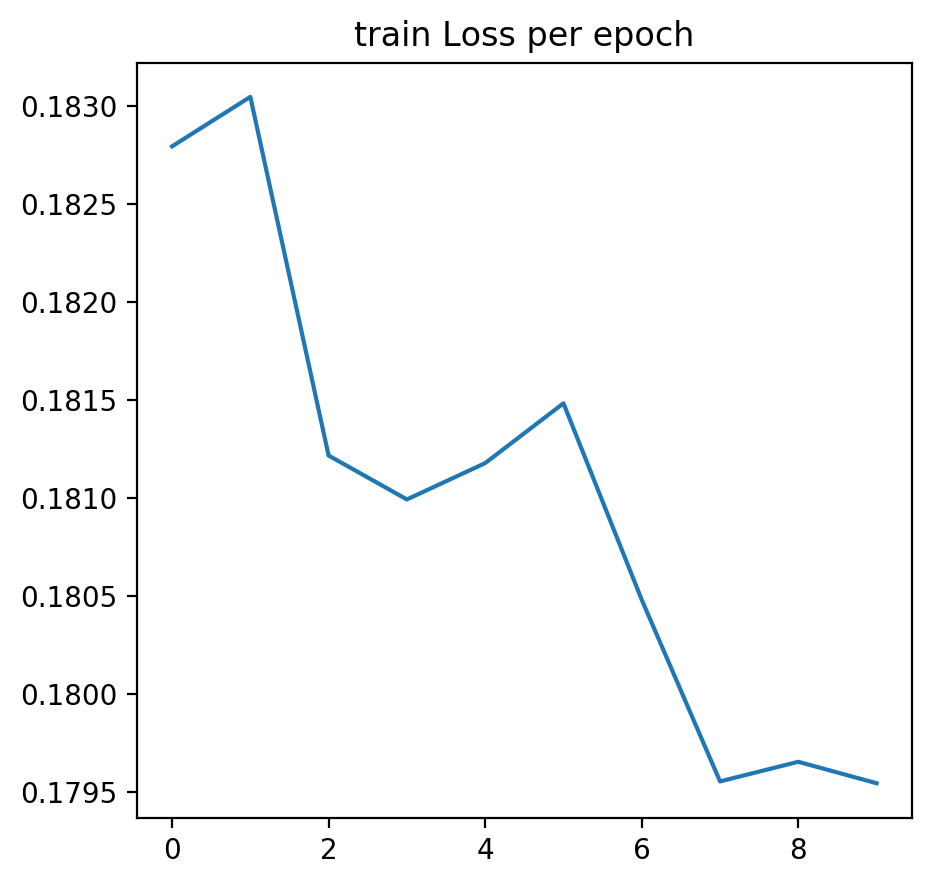

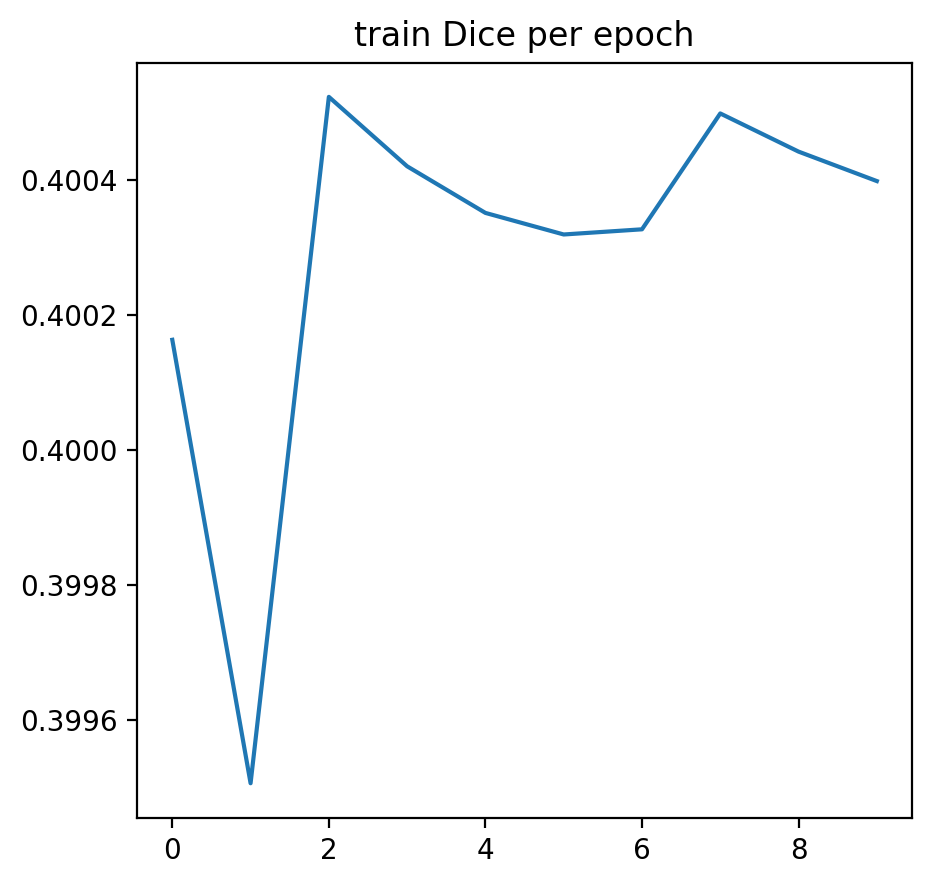

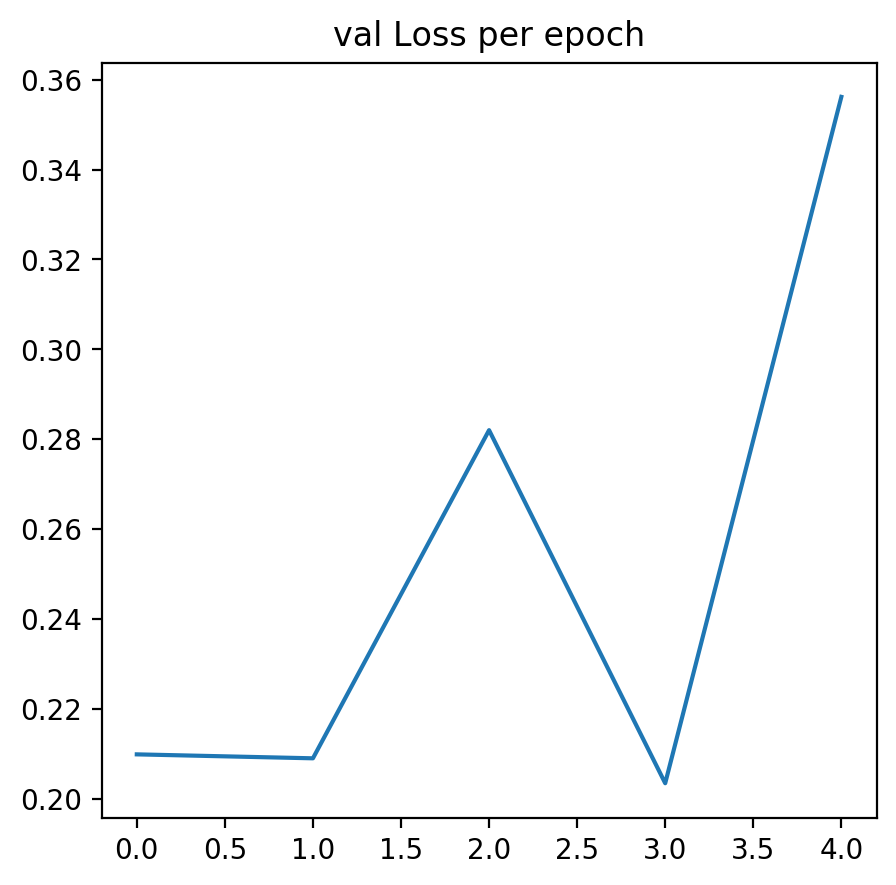

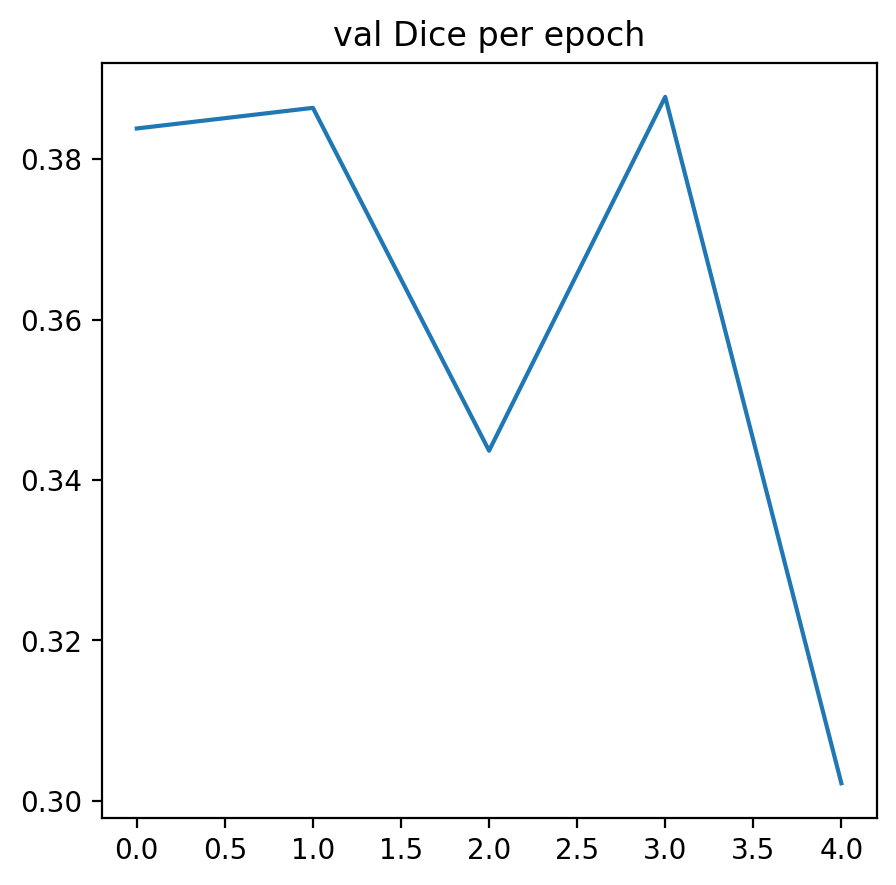

In [19]:
model, loss_dict, dice_dict, ts_dict, best_model_wts = train_eval_model2(model, dataloaders ,loss_function, 
                                                                        optimizer, best_loss=0.2, num_epochs=10,print_every=5, 
                                                                        eval_every = 2, to_eval = True)

Epoch 1/3
----------


/home/ht1162/miniconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


current epoch train dice loss is 497.029388
current epoch train dice coef is 1110.122437
training 1 epoch takes 1684.940484
current epoch val dice loss is 172.187483
current epoch val dice coef is 156.392822
valing 1 epoch takes 1785.615978
current ts is 0.461235
printing test image


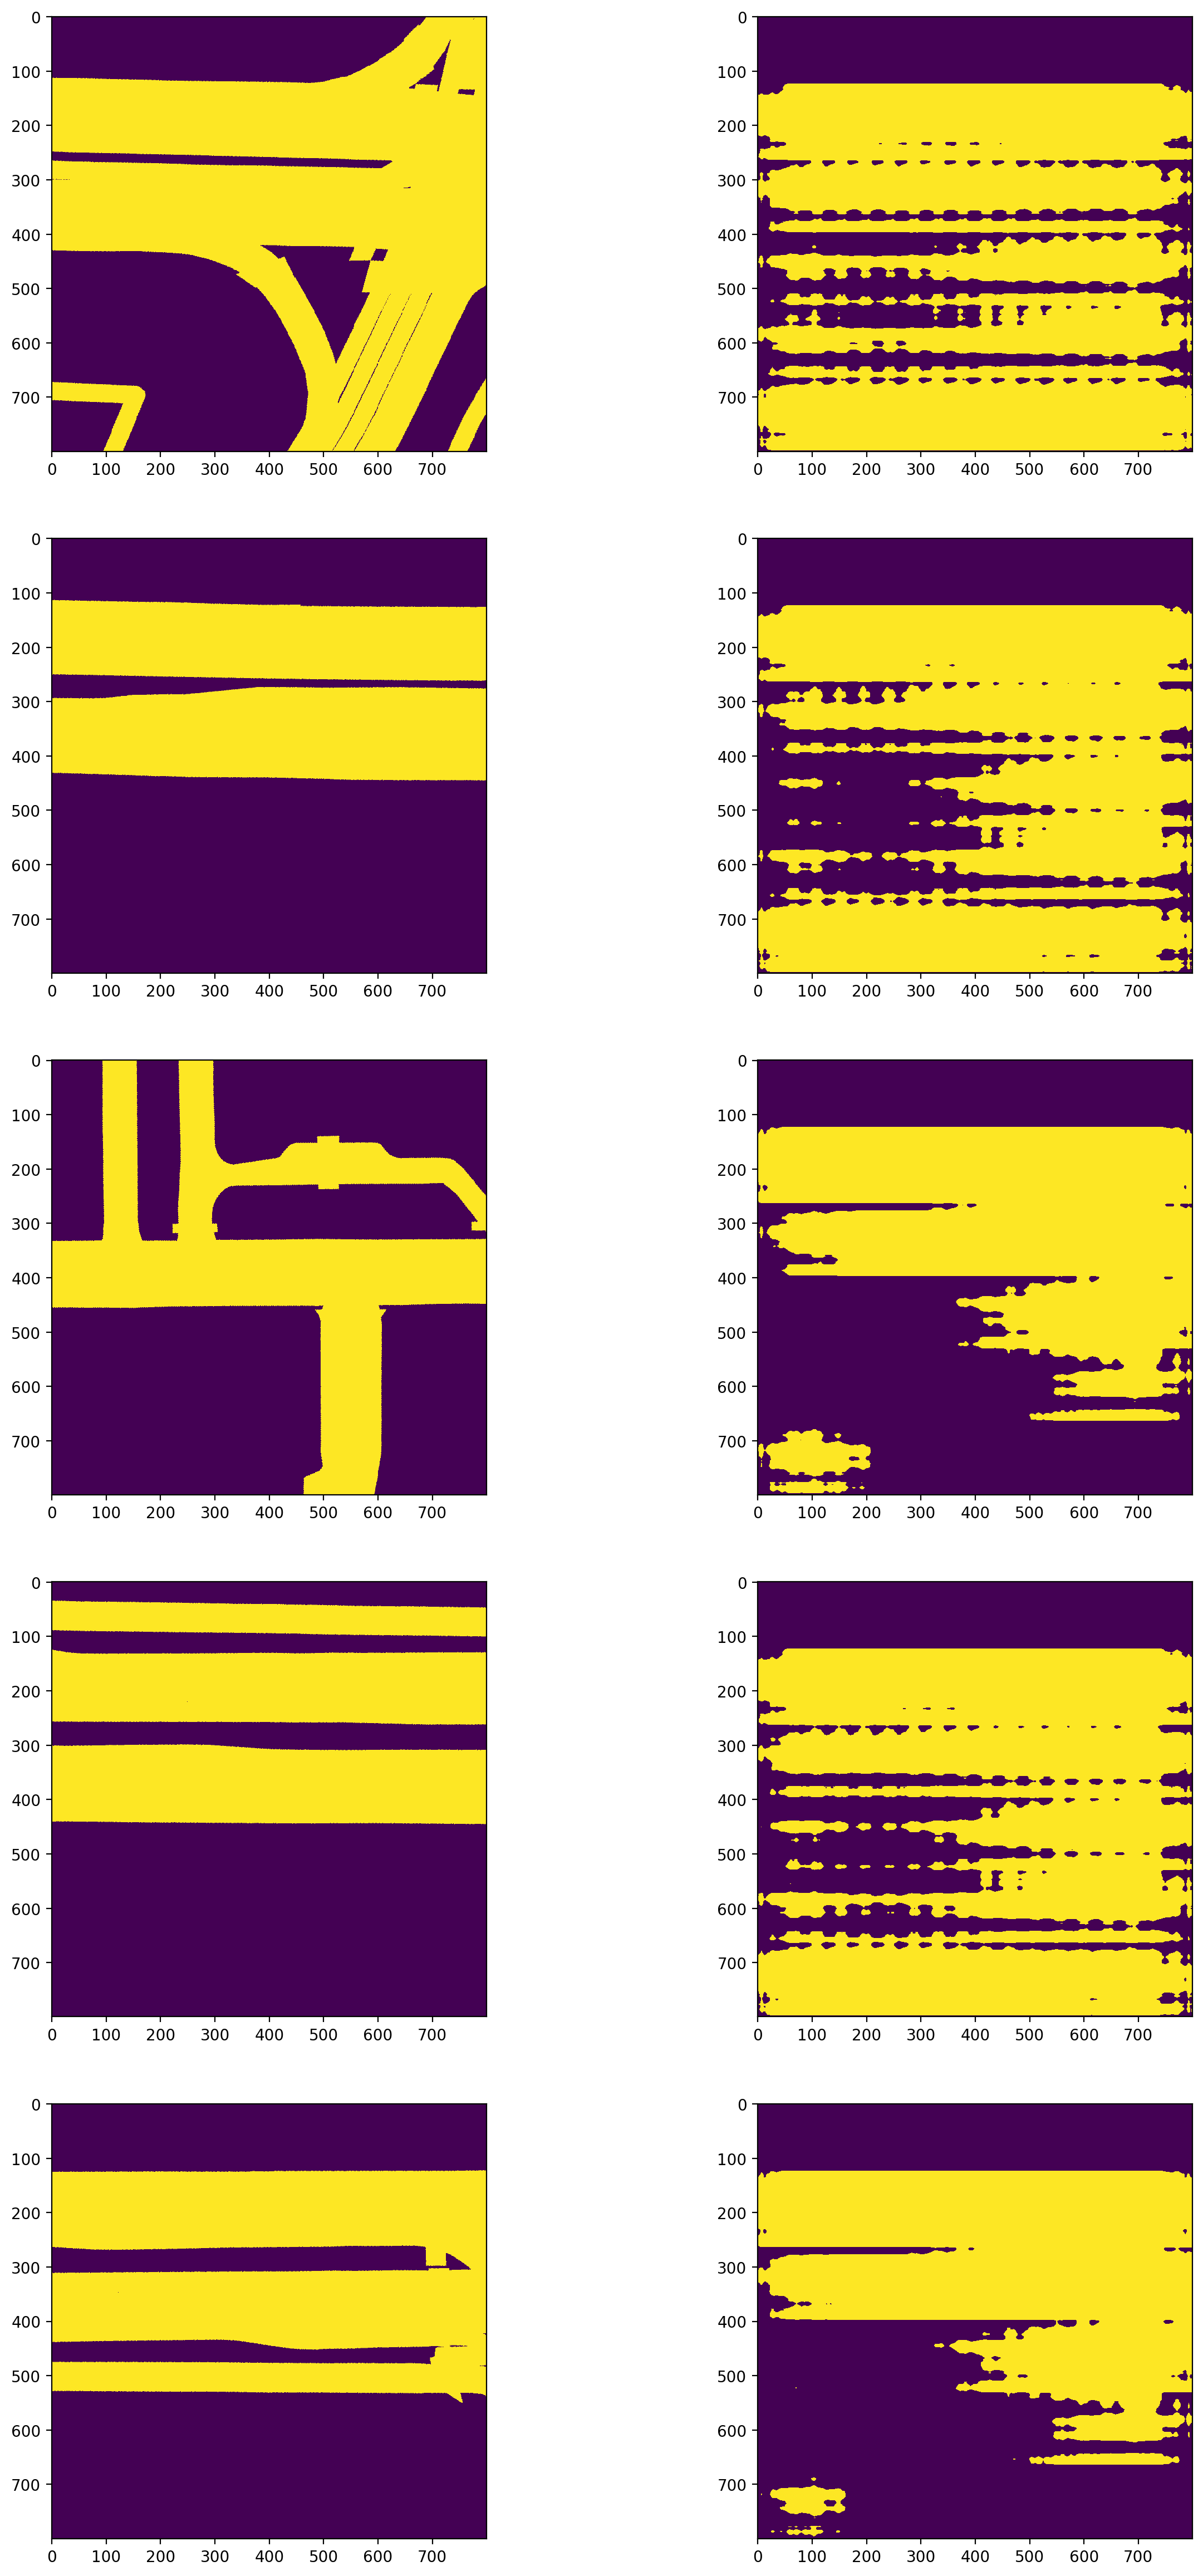

Epoch 2/3
----------
current epoch train dice loss is 496.893113
current epoch train dice coef is 1110.232666
training 1 epoch takes 1691.829692
current epoch val dice loss is 163.991890
current epoch val dice coef is 160.971970
valing 1 epoch takes 1792.346175
current ts is 0.478232
Epoch 3/3
----------
current epoch train dice loss is 500.294197
current epoch train dice coef is 1110.197632
training 1 epoch takes 1688.968527


In [ ]:
model, loss_dict, dice_dict, ts_dict, best_model_wts = train_eval_model2(model, dataloaders ,loss_function, 
                                                                        optimizer, best_loss=0.2, num_epochs=3,print_every=5, 
                                                                        eval_every = 1, to_eval = True)